# P3 - Data Wrangling - S.Jaeger submission for Udacity Nanodegree

## Background Information
For the purpose of this final project I choose as working location my place of living which is a medium sized peri- urban town called Tournefeuille, nearby Toulouse in the south west of France. Please find below a couple of pictures from Tournefeuille (source [2]):
<table border="0">
<tr>
<td>
<a title="By Melifica (Own work) [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY-SA 3.0 (http://creativecommons.org/licenses/by-sa/3.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3AEglise_St_Pierre_Tournefeuille.JPG"><img width="256" alt="Eglise St Pierre Tournefeuille" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Eglise_St_Pierre_Tournefeuille.JPG/512px-Eglise_St_Pierre_Tournefeuille.JPG"/></a>
</td>
<td>
<a title="By TomKr     Image created for the Blazon Project of the French Wikipedia [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY-SA 3.0 (http://creativecommons.org/licenses/by-sa/3.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3ABlason_ville_fr_Tournefeuille_(Haute-Garonne).svg"><img width="256" alt="Blason ville fr Tournefeuille (Haute-Garonne)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Blason_ville_fr_Tournefeuille_%28Haute-Garonne%29.svg/512px-Blason_ville_fr_Tournefeuille_%28Haute-Garonne%29.svg.png"/></a>
</td>
<td>
<a title="By Map data (c) OpenStreetMap contributors, CC-BY-SA   • Shape files infrastructure: railway, highways, water: all originally by OpenStreetMap contributors. Status december 2011 • Label and Insee code commune: from Geofla (note that commune boundaries are also available under free license at geofla, but not near acceptable quality due to extreme simplification!) • Data for exact commune* and department boundaries: derived via osm download geofabrik.de and osm2pgsql, OpenStreetMap contributors. • Data for landuse: OSM / Corine land cover, 2006 ([1]) • Mentioned sources combined and exported for each commune using a script by Michiel1972 *note: shown commune boundaries are from OSM dump May 2012; at that time about 90% complete (derived work, see author details) [CC BY 2.0 (http://creativecommons.org/licenses/by/2.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3AMap_commune_FR_insee_code_31557.png"><img width="256" alt="Map commune FR insee code 31557" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Map_commune_FR_insee_code_31557.png/512px-Map_commune_FR_insee_code_31557.png"/></a>
</td>
</tr>
</table>


## Data source

To retrieve Tournefeuille data, I used Mapzen Metro Extracts [3]. As you can imagine, Tournefeuille was not part of the popular extracts, so I had to create an account and generate a custom one centered around Tournefeuille. Luckily enough, it was well over 50 Mo (75 Mo exactly).<BR>
Rather than sampling every k line, I also generated a much smaller dataset (a subset of the much bigger Tournefeuille one) centered on my home (< 1 Mo), for debugging purposes.

## Implementation
For the sake of clarity and conciseness, my choice has been to externalize most of the code into a separate <b>P3</b> python package delivered with this report. This notebook makes call to this external package. This significantly reduces the size of the report itself and enables to highlight only the interesting piece of codes in the report.

## Problems encountered in my map
By its collaborative nature, OpenStreetMap data is created manually by individual human users. As such, we expect the data set to include some quality issues.
To audit the data, I started from the code seen within the lessons. Some of the encountered problems where dealing with the fact that my data was coming from another <b>locale and language</b> than the one from the lessons:<BR>
For example, within the list of expected street types, there is one called "Allée" in French (which translates to "Alley") that takes an accent. Using the raw string "Allée", the code was working well when the strings were identical but was wrongly identifying as errors some of the alleys which where written using unicode encoding "All\xe9e". So I had to encode this value in unicode within the "expected" variables to make the code able to deal with both "Allée" and "All\xe9e".<BR>
~~~python
expected = ["Rue", "Avenue",u"All\xe9e",
            "Rond-Point"]
~~~
Then, I had to modify the regular expression to take the 1st word of an adress, as in French, the type of street is at the very beginning of an adress:
~~~python
street_type_re = re.compile(r"(\b\S+)", re.IGNORECASE)
~~~
Once this done, the auditing function was ready to operate on my dataset:

In [3]:
# import all necessary packages and functions.
import csv
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn

import os
import sys
import pprint as pp
#Trick to be able to import my own P3 module stored in the "src" folder from the "report" folder
module_path = os.path.abspath(os.path.join('..\\src'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Package containing specific code for this P3 assignment
from P3.OSMAudit import audit
%matplotlib inline

OSMFILESMALL = "..\\data\\TournefeuilleSmall\\ex_skRaCfhoUs2YH1UkxceUcxB7i7yG2.osm"
OSMFILELARGE = "..\\data\\TournefeuilleLarge\\ex_ifADycQ6ZEYtQ1EGQpj1mL17xbgci.osm"

audited_types = audit(OSMFILELARGE)
print("Audited street names:")
pp.pprint(dict(audited_types[0]))
print("\nAudited post codes:")
pp.pprint(dict(audited_types[1]))

Audited street names:
{'27': set(['27 Boulevard Vincent Auriol']),
 '51': set(['51 Boulevard Vincent Auriol']),
 '64': set(['64 Boulevard Vincent Auriol']),
 u'Av.': set([u'Av. Ari\xe8ge']),
 u'all\xe9e': set([u'all\xe9e des Alpilles']),
 'impasse': set(['impasse Marcel Paul']),
 'place': set(['place J. Sauvegrain']),
 'rue': set(['rue des chevreuils'])}

Audited post codes:
{'31170 Tournefeuille': set(['31170 Tournefeuille'])}


On my dataset, the auditing function checked validity for street names and post codes, and highlighted 3 different kinds of issues for streetnames and one single issue for postcodes:
Streetnames:<BR>
- Adresses that wrongly started with an house number rather than having it encoded within an "addr:housenumber".
- "Av." abbreviation rather than the full "Avenue".
- Some street types that starts with lowercase rather than using capitals ("allée","impasse","place","rue").<BR>

Postcodes:<BR>
- French postcodes shall be made up of 5 digits. One of them is followed by the name of the town which is obviously a mistake.

Correcting the audited issues has been centralized in the cure_name() function that takes a name as input & returns a cured name:
- The postcode issue is corrected by keeping only the 5 first chars.
- The Av. abbreviation is replaced by its matching synonym in a hard coded dictionary, as described in the lessons.
- The lowercases are cured using the title() method:
~~~python
name = name.title()
~~~
- The correction of adresses starting with digits is more complex:<BR>
First, the leading digits are suppressed from the string within cure_name() using a regular expression:
~~~python   
    startswithtwodigits = re.search('^\s*([0-9][0-9])',name)
    
    # striping the digits
    if startswithtwodigits:
        name = name.replace(startswithtwodigits.group(1),"").lstrip()
~~~

But this is not sufficient to fully correct the issue as in those cases, to ensure <b>consistency & uniformity</b>, the XML structure of the OSM file also needs to be modified by adding the missing house number under the considered node or way as follows:
~~~xml 
	<tag k="addr:housenumber" v="27" />
~~~

Implementing this XML modification is done in the cureData function. It required to reparse the whole file and I choosed to replicate its content in a cured.osm file, not to alter the original one. Note that the whole process is again using SAX to enable large files handling and as soon as an element is read & cured it is serialized back in the duplicated cured file:
~~~python 
	for event, elem in ET.iterparse(osm_file, events=("start",)):
        ...                  
        cured_osm.write(ET.tostring(elem))
~~~
Let us launch the cureData method to generate the cured file:

In [4]:
from P3.OSMAudit import cureData
CUREDOSMLARGE = "..\\data\\TournefeuilleLarge\\cured.osm"
#generating cured.osm
cureData(OSMFILELARGE,CUREDOSMLARGE)

Cured data generated successfully


The remaining steps of the process are described in below picture and also reuse the code skeleton seen during the udacity lessons & quiz:
<img width="640" alt="Transform Load workflow" src="./Workflow.jpg"/>
Starting from the cured dataset, let us generate the json file and import it within Mongo DB (as this step is fairly similar to the code seen during the lessons, I assume it is not useful to have it described here - The only thing worth to mention is that we paid attention to drop the collection before inserting the parsed records so that the code can be repeated):


In [5]:
from P3.OSM2JSON import OSM2JSON
from P3.JSON2Mongo import JSON2Mongo

OSM2JSON(CUREDOSMLARGE)
JSONLARGE = "..\\data\\TournefeuilleLarge\\cured.osm.json"
#At each execution, collections is first dropped and then re-created
JSON2Mongo(JSONLARGE,"mongodb://localhost:27017")

Successful conversion from OSM to JSON
json cured file read successfully
{u'id': u'8138783', u'_id': ObjectId('5893aa098c6fdd83ac170bfa'), u'type': u'node', u'pos': [43.5663504, 1.379521], u'created': {u'uid': u'134812', u'changeset': u'10487955', u'version': u'3', u'user': u'Ziaou', u'timestamp': u'2012-01-24T20:03:13Z'}}


## Overview of the Data
Let us retrieve the number of objects and the split between nodes and ways.

In [6]:
from P3.MongoQueries import *
print("Number of nodes in the collection:")
pp.pprint(get_db().OSM.count())

print("\nAggregate pipeline to retrieve the number of records by type:")
pp.pprint(make_pipelineNbRecordsByType())
print("Result:")
pp.pprint(getNbRecordsByType())

print("\nAggregate pipeline to retrieve the number of records having an address:")
pp.pprint(make_pipelineWithAddress())
print("Result:")
pp.pprint(getNbRecordsWithAddress())

print("\nAggregate pipeline to retrieve the number of records having an house number:")
pp.pprint(make_pipelineWithHouseNumber())
print("Result:")
pp.pprint(getNbRecordsWithHouseNumber())

print("\nNumber of distinct users:")
print(len(get_db().OSM.distinct("created.user")))

Number of nodes in the collection:
385710

Aggregate pipeline to retrieve the number of records by type:
[{'$group': {'_id': '$type', 'count': {'$sum': 1}}}, {'$sort': {'count': -1}}]
Result:
[{u'_id': u'node', u'count': 331344}, {u'_id': u'way', u'count': 54366}]

Aggregate pipeline to retrieve the number of records having an address:
[{'$group': {'_id': {'$gt': ['$address', None]}, 'count': {'$sum': 1}}}]
Result:
[{u'_id': False, u'count': 381944}, {u'_id': True, u'count': 3766}]

Aggregate pipeline to retrieve the number of records having an house number:
[{'$group': {'_id': {'$gt': ['$address.housenumber', None]},
             'count': {'$sum': 1}}}]
Result:
[{u'_id': False, u'count': 382019}, {u'_id': True, u'count': 3691}]

Number of distinct users:
259


Using Panda, let us make a few calculations from those raw digits and have some charts to better figure out what they really mean.

         0
0  0.85905
1  0.14095
          0
0  0.990236
1  0.009764


98.00849707912904

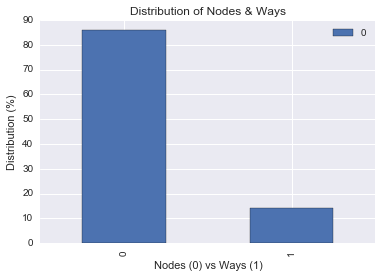

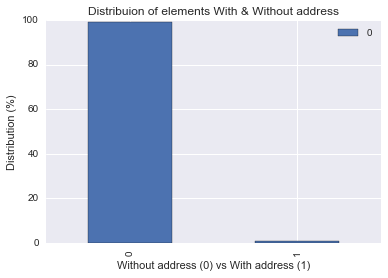

In [7]:
totalNbRecords = float(get_db().OSM.count())
nodewayrepartition = [getNbRecordsByType()[0]["count"]/totalNbRecords,getNbRecordsByType()[1]["count"]/totalNbRecords]
df1 = pd.DataFrame(nodewayrepartition)
(100* df1).plot(title="Distribution of Nodes & Ways",kind="bar")
axes = plt.xlabel("Nodes (0) vs Ways (1)")
axes = plt.ylabel("Distribution (%)")
pp.pprint(df1)

hasAddress = [getNbRecordsWithAddress()[0]["count"]/totalNbRecords,getNbRecordsWithAddress()[1]["count"]/totalNbRecords]
df2 = pd.DataFrame(hasAddress)
(100* df2).plot(title="Distribuion of elements With & Without address",kind="bar")
axes = plt.xlabel("Without address (0) vs With address (1)")
axes = plt.ylabel("Distribution (%)")
pp.pprint(df2)

proportionOfAdressesWithHouseNumber = 100 *float(getNbRecordsWithHouseNumber()[1]["count"])/getNbRecordsWithAddress()[1]["count"]
proportionOfAdressesWithHouseNumber

The collection is made up of <b>385710 xml entities</b> amongst which <b>86% </b>are nodes and<b> 14% </b>are ways.
Within all the set of nodes and ways, less than one per cent have an address.<BR>Turning those raw digits in percentage and visualizing the bar charts help to realize the very low proportion of existing addresses in this dataset.<BR>
Amongst those, we see that only <b>two per cent</b> miss an house number. On the contrary, this digit is reassuring as it suggests that when an adress has been filled, it is often of good quality.<BR>
Note that this figure has been a little improved by curing the data in the aboves decribed pre-processing stage as I took care of inserting a couple of house numbers otherwise missing.

## Other ideas about the datasets
So far we have mostly focusing on the tags already explored in the lessons (address, way, node) and we have seen that, only dealing with another data set, encountered issues can be very different, and can bring a lot of additional work.
This makes me realize how hard it must be when dealing with a huge set of data to have code really data agnostic that can handle all kind of problems, even some you can not imagine in advance.

Mongo makes it convenient also to check for the good healing of the data does in the previous steps. Let us do that for postcodes: 


In [8]:
print("\nAggregate pipeline to retrieve the postcodes and their usage:")
pp.pprint(make_pipelinePostcodes())
print("Result:")
pp.pprint(getPostCodes())


Aggregate pipeline to retrieve the postcodes and their usage:
[{'$group': {'_id': '$address.postcode', 'count': {'$sum': 1}}},
 {'$sort': {'count': -1}}]
Result:
[{u'_id': None, u'count': 385582},
 {u'_id': u'31170', u'count': 75},
 {u'_id': u'31770', u'count': 25},
 {u'_id': u'31300', u'count': 14},
 {u'_id': u'31100', u'count': 6},
 {u'_id': u'31830', u'count': 3},
 {u'_id': u'31000', u'count': 2},
 {u'_id': u'31070', u'count': 1},
 {u'_id': u'31270', u'count': 1},
 {u'_id': u'31036', u'count': 1}]


Above is some sort of post-auditing result thanks to mongo db, where we can see that our data set does not have any odd value anymore.<BR>
The same quality check could be done on street names (but would generate too much outputs for the sake of this report), with an almost identical aggregate query, which shows no interest.<BR>

## Improving the data:
From previous request, we can see that the number of records not having a Postcode is <b>lower</b> from the number of records not having an address, which means that some records have an adress without postcode, which shall not be possible in real life.<BR>

A possible improvement could be to issue programmatically some request to some other webservice (e.g Googlemaps API) to retrieve or complete the address with the correct postcode. 

<b>Benefits</b>:
- This would enable to cure one identified flaw (incompleteness) seen in this dataset programmatically.
- Curing the data programmatically would enable to deal with huge datasets and to cure a bigger amount of data. 

<b>Anticipated Problems</b>:
- As the adress is not complete (postcode missing), I assume Googlemaps API would need some Geo-position (lat, long) to identify a given element. This Geo position might not be always available.
- Another problem is that I am not sure that it would be really legal: extracting valuable data from google maps to build a separate standalone concurrent db might not be allowed.

## Conclusion
In this assignment we have covered a full data pipeline where the data goes through many corrections, transformations and queries steps. Approach from the udacity lessons and from this implementation is to develop this using python and high level python libraries. <BR>
Another way to handle some parts of this assignment could have been to use an ETL (Extract, Transform, Load) such as Talend [4] or CloverETL [5].<BR> Knowing this kind of tool is also a great asset when collecting data from various sources having some quality issues. I can imagine it could also be relevant to use ETL in the frame of data science subjects - it might be an idea for a future additional chapter of this Udacity nanodegree ?


**Sources & References:**<BR>
Original assignment from udacity:<BR>
[1] Udacity https://classroom.udacity.com/nanodegrees/nd002/parts/0021345404/modules/316820862075463/lessons/3168208620239847/concepts/77135319070923<BR><BR>
Background information on Data Wrangling and investigated dataset:<BR>
[2] Wikimedia commons https://commons.wikimedia.org/wiki/Category:Buildings_in_Tournefeuille<BR>
[3] Mapzen https://mapzen.com/<BR><BR>
Other references:<BR>
[4] Talend https://www.talend.com/<BR>
[5] Clover ETL http://www.cloveretl.com/<BR>

**Revisions:**<BR>
    [1] - Tuesday the 31th of January, original submission <BR>